In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

from model_segformer import segformer
from utils.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import Normalize as Normalize_th
import torch.nn.functional as F
import nopdb

class LDoptions:
    def __init__(self):
        # path config
        self.pooling_method = "avg"
        self.embed_dims = [32, 64, 160, 256]
        self.num_heads = [1, 2, 5, 8]
        self.mlp_ratios = [4, 4, 4, 4]
        self.without_qkv_bias = True
        self.encoder_depths = [2, 2, 2, 2]
        self.sr_ratio = [2, 2, 1, 1]
        self.attention_drop_rate = 0.0
        self.drop_path_rate = 0.1
        self.se_layer = True

In [2]:
def decode_segmap(seg_pred):
    color_map = {
    0: [0, 0, 0],  # black
    1: [0, 0, 255],  # Blue
    2: [0, 255, 0],  # Green
    3: [255, 0, 0],  # Red
    4: [255, 255, 0],  # Yellow
    }
    
    color_seg_map = np.zeros((seg_pred.shape[0], seg_pred.shape[1],3),dtype=np.uint8)
    for i in range(1, 5):
        pred = seg_pred[:,:,i] > 0.3
        color_seg_map[pred == 1] = color_map[i]
    return color_seg_map

def agg_segmentation_wrapper(inp):
    output = net(inp)
    # idx = (output[0] > 0.3).nonzero()
    # selected_inds = torch.zeros_like(output[0]).scatter_(1, idx,1)
    selected_inds = output[0] > 0.3
    return (output[0]*selected_inds).sum(dim=(2,3))


loading pretrained model
torch.Size([1, 5, 288, 512])


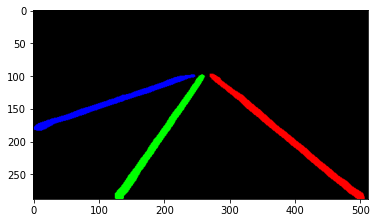

In [3]:
model_config = LDoptions()
net = segformer(model_config, "Tusimple")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
weight_path = "/home/automan/wuguanjie/SCNN_Pytorch/experiments/exp_TU_baseline_flip_sr2211_GELU_se/exp_TU_baseline_flip_sr2211_GELU_se_best.pth"
save_dict = torch.load(weight_path, map_location="cpu")
net.load_state_dict(save_dict["net"])
net.to(device).eval()

# img_path = "/home/automan/wuguanjie/TuSimple/train/clips/0531te/1492626253262712112/20.jpg"
img_path = "/home/automan/wuguanjie/TuSimple/test/clips/0601/1494452383592719171/20.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize
img = cv2.resize(img, (512,288))

#to tensor
img = img.transpose(2,0,1)
img = torch.from_numpy(img).type(torch.float)/255.

# normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = Normalize_th(mean,std)
img = transform(img)

img = torch.unsqueeze(img, 0).to(device)
output = net(img)
print((output[0] > 0.3).shape)
seg_pred = torch.squeeze(F.softmax(output[0], dim=1), 0)
seg_pred = seg_pred.detach().cpu().numpy()
seg_pred = np.ascontiguousarray(np.transpose(seg_pred, (1,2,0)))
color_seg_map = decode_segmap(seg_pred)
plt.imshow(color_seg_map)

In [4]:
print(net.encoder.block4[1])

Block(
  (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (q): Linear(in_features=256, out_features=256, bias=True)
    (kv): Linear(in_features=256, out_features=512, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=256, out_features=256, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (drop_path): DropPath(drop_prob=0.100)
  (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (dwconv): DWConv(
      (dwconv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1024)
    )
    (act): GELU()
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
)


In [5]:
with nopdb.capture_call(net.encoder.block3[0].attn.forward) as attn_call:
    net(img)

In [6]:
attn_call.locals.keys()

dict_keys(['W', 'H', 'x', 'self', 'C', 'N', 'B', 'q', 'kv', 'v', 'k', 'attn'])

True

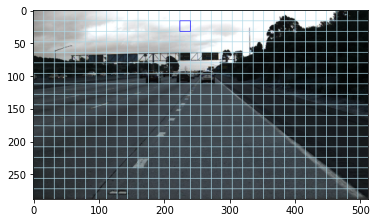

In [19]:
# vis_img = cv2.imread("/home/automan/wuguanjie/TuSimple/train/clips/0531te/1492626253262712112/20.jpg")
vis_img = cv2.imread("/home/automan/wuguanjie/TuSimple/test/clips/0601/1494452383592719171/20.jpg")
vis_img = cv2.resize(vis_img, (512,288))
# vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
num_row = 18
num_col = 32
cell_size = 16
for i in range(num_col):
  x = i*cell_size
  for j in range(num_row):
    y = j*cell_size
    cv2.rectangle(vis_img, (x,y), (x+16, y+16), (173,216,230),thickness =1)
ul = (224, 16)
br = (240 ,32)
cv2.rectangle(vis_img, ul, br, (0,0,255),thickness =1)
plt.imshow(vis_img)
cv2.imwrite("/home/automan/wuguanjie/report_vis/attention_map_block3/sky2_img.jpg", vis_img)

torch.Size([1, 5, 576, 576])


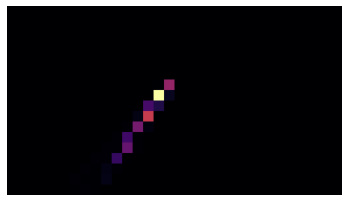

In [24]:
import torch.nn as nn
import matplotlib.pyplot as plt
weights = attn_call.locals['attn'] #(1,1,9216,144)
print(weights.shape)
# w_featmap = 72//2
# h_featmap = 128//2
w_featmap = 18
h_featmap = 32
attentions = weights[0,4,46,:]
attentions = attentions.reshape(1, w_featmap,h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].detach().cpu().numpy()
# # convert to rgba and take only rgb
cmap = plt.cm.ScalarMappable(cmap=plt.get_cmap('inferno'))
cmap.set_array(attentions[0])
attentions_4c = cmap.to_rgba(attentions[0])
attentions_3c = attentions_4c[:,:,:3]
plt.imshow(attentions_3c, cmap="inferno")
plt.axis('off')
plt.savefig("/home/automan/wuguanjie/report_vis/attention_map_block3/sky2_head4.png", bbox_inches = 'tight', pad_inches = 0)

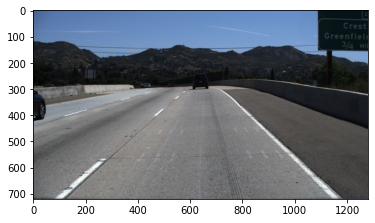

In [8]:
img_path = "/home/automan/wuguanjie/TuSimple/train/clips/0531te/1492626253262712112/20.jpg"
pred_img = cv2.imread(img_path)
pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
plt.imshow(pred_img)

(288, 512, 4)


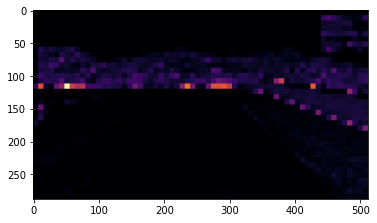

In [39]:
cmap = plt.cm.ScalarMappable(cmap=plt.get_cmap('inferno'))
cmap.set_array(attentions)
cmap_3d = cmap.to_rgba(attentions)
plt.imshow(cmap_3d[:,:,:3])
# attentions = attentions[:,:,0]
print(cmap_3d.shape)

torch.Size([72, 128])
(1, 288, 512)


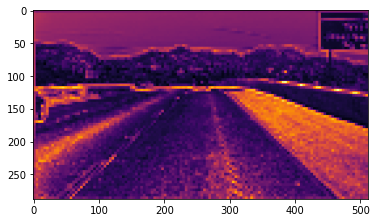

In [9]:
import torch.nn as nn
import matplotlib.pyplot as plt
x = attn_call.locals['x'] #(1,9216,32)
x = x.transpose(1,2)

w_featmap = 72
h_featmap = 128

featmap = x[0,26,:]

featmap = featmap.reshape(w_featmap,h_featmap)
print(featmap.shape)
featmap = nn.functional.interpolate(featmap.unsqueeze(0).unsqueeze(0), scale_factor=4, mode="nearest")[0].detach().cpu().numpy()
print(featmap.shape)
plt.imshow(featmap[0], cmap="inferno")